# Utah Sunrise & Sunset Car Crash Data

# Introduction
The state of Utah has published a dataset containing information about car crashes over a period of more than four years. The goal of this project is to examine the statewide information in aggregate, and answer one primary question: Does the rising and setting of the sun have a meaningful influence on car crash frequency?

The crash data for this project came from the [Utah Open Data Catalog](https://opendata.utah.gov/). This project uses the [State of Utah Crash Data 2015-2019](https://opendata.utah.gov/Public-Safety/State-of-Utah-Crash-Data-2015-2019/7ihm-46s4). The data for sunrise and sunset time was manually scraped from [Time and Date](https://www.timeanddate.com/sun/usa/salt-lake-city), using the data for Salt Lake City as an approximation for the whole state. 

# 1 Load Data
## 1.1 Library Importing
For this project, we will only need three packages, all part of the Tidyverse: dplyr for dataframe management, lubridate for dealing with datetimes, and ggplot2 for plotting the data.

In [ ]:
#import necessary libraries: dplyr, ggplot2, and lubridate
library(dplyr)
library(lubridate)
library(ggplot2)

## 1.2 Data Importing

We will import the crash dataset, but only some of the columns (most of which are booleans). In addition to this, we will also need the dataset containing sunrise and sunset times for Utah. 

In [2]:
#define the data types of the colums
col_types <- c('CRASH_DATE' = 'character', 
               'PEDESTRIAN' = 'logical', 
               'BICYCLIST_' = 'logical', 
               'MOTORCYCLE' = 'logical', 
               'IMPROPER_R' = 'logical', 
               'UNRESTRAIN' = 'logical', 
               'DUI' = 'logical', 
               'INTERSECTI' = 'logical', 
               'WILD_ANIMA' = 'logical', 
               'DOMESTIC_A' = 'logical', 
               'OVERTURN_R' = 'logical', 
               'COMMERCIAL' = 'logical', 
               'TEENAGE_DR' = 'logical', 
               'OLDER_DRIV' = 'logical', 
               'NIGHT_DARK' = 'logical', 
               'SINGLE_VEH' = 'logical', 
               'DISTRACTED' = 'logical', 
               'DROWSY_DRI' = 'logical', 
               'ROADWAY_DE' = 'logical')
#import the csv using col_types as the columnClasses
crash <- read.csv("State_of_Utah_Crash_Data_2015-2019.csv", stringsAsFactors = TRUE, colClasses=col_types)
SRSS_times <- read.csv("SLC_sun_schedule.csv")

## 1.3 Data Restructuring
First we will convert the time to a more useable POSIXct, then we will extract features from the data, such as hour, date, and 15- or 13-minute block.  We will then join the two imported datasets on date (mm/dd)

In [3]:
#convert CRASH_DATE column to datetime using format mm/dd/yyyy H:M:S AM/PM
crash$CRASH_DATE <- as.POSIXct(crash$CRASH_DATE, tz = "America/Denver", format = "%m/%d/%Y %I:%M:%S %p")

#create columns that contain the hour, clock time, and calendar day (w/o year) of the crash
crash <- crash %>%
    mutate(crash_hour = hour(CRASH_DATE)) %>%
    mutate(crash_time = strftime(CRASH_DATE, format="%H:%M:%S")) %>%
    mutate(crash_day = strftime(CRASH_DATE, format="%m/%d")) %>%
    mutate(crash_time_15 = crash_hour + ((floor(minute(CRASH_DATE)/15))/4)) %>%
    mutate(crash_time_30 = crash_hour + ((floor(minute(CRASH_DATE)/30))/2))

#Use only columns 2 through 11 of the SRSS_times df
SRSS_times <- SRSS_times[c(2:11)]

#inner join the two dfs so SRSS data is attached to each crash
crash_srss <- crash %>%
    inner_join(SRSS_times, by = c("crash_day" = "Date2"))

We only want to deal with the "clock time" of the crash when comparing it to the time of sunrise or sunset. We can assing all morning crashes to a sunrise dataframe, and all evening crashes to a sunset dataframe.

In [5]:
#graph generic crash data (all crashes) for 2 hrs before and after sunrise and sunset (2 graphs)
#create separate dfs for morning (crash_sr) and evening (crash_ss)
crash_sr <- crash_srss %>%
    filter(crash_hour <= 11)
crash_ss <- crash_srss %>%
    filter(crash_hour >= 12)

#create a new column in both crash_sr and crash_ss dfs to indicate time difference between the crash
#and sunrise or sunset
crash_sr <- crash_sr %>%
    mutate(sr_diff = strptime(Sunrise, format = "%H:%M:%S") - strptime(crash_time, format = "%H:%M:%S"))

crash_ss <- crash_ss %>%
    mutate(ss_diff = strptime(Sunset, format = "%H:%M:%S") - strptime(crash_time, format = "%H:%M:%S"))

Find the difference between the time of the crash, and the sunrise or sunset event. Assign this values to either sr_diff or ss_diff. Filter for values that fall within 1 hour of the sunrise or sunset.

In [6]:
#for both dfs, convert drtn type to numeric, in units of minutes
#filter for events that are between -60 and 60

crash_sr$sr_diff <- as.numeric(crash_sr$sr_diff, units = "mins")

crash_sr_narrow <- crash_sr %>%
    filter(sr_diff >= -60 & sr_diff <= 59)

crash_ss$ss_diff <- as.numeric(crash_ss$ss_diff, units = "mins")

crash_ss_narrow <- crash_ss %>%
    filter(ss_diff >= -60 & ss_diff <= 59)

# 3 Visualization
Plot each of these dataframes in a histogram, with the sunrise or sunset at the center of the x-axis.

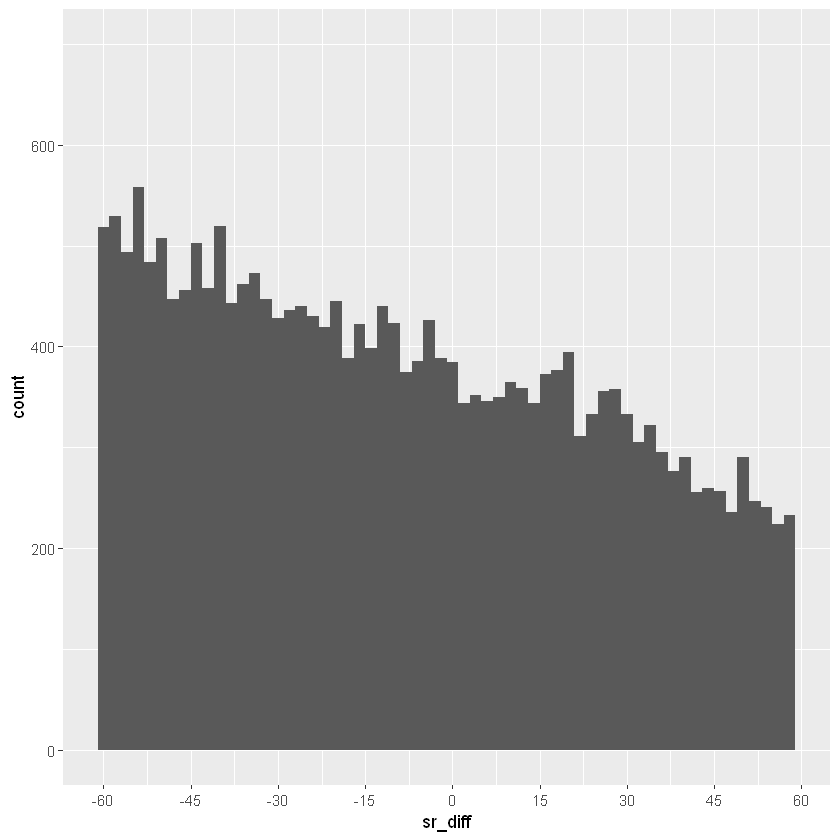

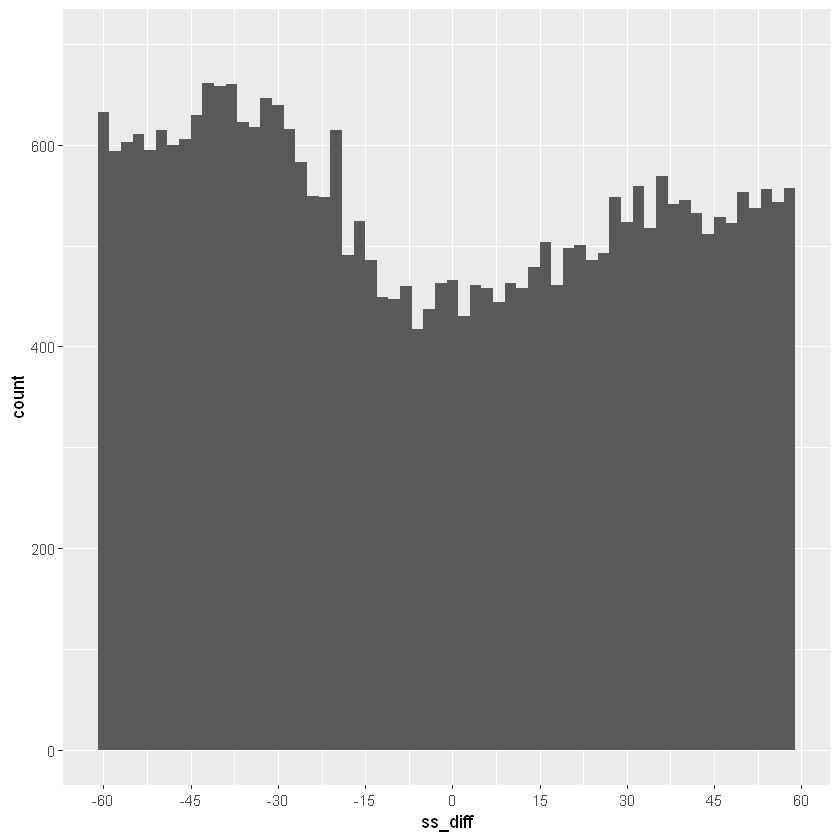

In [7]:
#graph the density plot of crashes around sunrise and sunset
ggplot(crash_sr_narrow, aes(x = sr_diff))+
    geom_histogram(binwidth = 2)+
    scale_x_continuous(breaks = seq(-60, 60, by = 15))+
    ylim(0, 700)

ggplot(crash_ss_narrow, aes(x = ss_diff))+
    geom_histogram(binwidth = 2)+
    scale_x_continuous(breaks = seq(-60, 60, by = 15))+
    ylim(0, 700)